In [1]:
import xgboost as xgb
import pandas as pd
xgb.__file__
import matplotlib
%matplotlib inline
import sklearn
#from sklearn import datasets
import numpy as np
#from sklearn.model_selection import train_test_split 
#from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, average_precision_score


/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
#all loss functinos assume you are running the default 

# user define objective function, given prediction, return gradient and second order gradient
# this is log likelihood loss
"""def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1.0-preds)
    print grad#, hess
    return grad, hess"""


def logregobj(y_true, y_pred):
    #labels = dtrain.get_label()
    #go a logistic transform on it
    preds = 1.0 / (1.0 + np.exp(-y_pred))
    grad = preds - y_true
    hess = preds * (1.0-preds)
    #print grad#, hess
    return grad, hess


#square loss function
def sq_loss(y_true, y_pred):
    #undo the automatic logistic transformation
    #preds = -np.log(1./preds - 1)
    #apply square loss to the predictions
    preds = (1- y_true*y_pred)**2 # the objective function
    grad = 2*-y_true*(1- y_true*y_pred)
    hess = 2*y_true**2 #? is this right?

    return grad, hess
    
    
    
    
def default(y_true, y_pred):
    #try mean sq errror
    preds = (1./y_true.shape[0])*(y_true - y_pred)**2
    grad = (1./y_true.shape[0])* -2*(y_true - y_pred)
    hess = np.zeros_like(grad)
    hess.fill(2 * (1./y_true.shape[0]))
    #hess = 2
    #print grad#, hess
    return grad, hess
    return grad, hess



#hinge loss function not possible due it not being differentialble at y*f(x) =1
#needs to use subgradient descent models

def quad_loss(y_true, y_pred):
    #signature ytrue, _ypred
    #labels = dtrain.get_label()
    #undo the automatic logistic transformation
    #preds = -np.log(1./preds - 1)
    preds = (y_true - y_pred)**2
    grad = -2*(y_true - y_pred)
    hess = np.zeros_like(grad)
    hess.fill(2)
    #hess = 2
    #print grad#, hess
    return grad, hess



User defined evaluation function, returns a pair metric_name, and result
NOTE: when you do customized loss function, the default prediction value is margin.
This may make builtin evaluation metric not function properly. For example, we are doing logistic loss, the prediction is score before logistic transformation. The builtin evaluation error assumes input is after logistic transformation.
Take this in mind when you use the customization, and maybe you need write customized evaluation function


In [27]:
df = pd.read_csv("../csvs/initial_orbital_elements.csv", index_col=0)
del df["runstring"]
del df["Rel_Eerr"]
df.head(10)

,Stable,instability_time,RHill12,RHill23,beta12,beta23,m1,a1,P1,e1,...,Omega2,f2,m3,a3,P3,e3,pomega3,inc3,Omega3,f3
0,0,1.235644e+07,0.026033,0.023222,8.508586,15.826967,3.414016e-05,1.0,0.999983,0.005031,...,1.573978,-0.567081,1.826900e-06,1.589043,2.003050,0.002515,-0.108162,0.065498,-1.192440,-0.614709
1,0,1.348749e+05,0.022704,0.031284,8.397002,15.367618,2.529838e-07,1.0,1.000000,0.010350,...,-1.749616,1.437355,1.955797e-05,1.671403,2.160777,0.072450,-0.343874,0.046939,-0.619350,0.192203
2,0,1.276381e+04,0.036304,0.032149,3.461288,25.229467,7.380789e-05,1.0,0.999963,0.051912,...,-0.032550,-0.317958,1.477931e-07,1.936762,2.695151,0.003395,3.419165,0.014535,2.795101,1.685406
3,1,1.000000e+09,0.011704,0.014963,18.513681,19.145889,5.174804e-07,1.0,1.000000,0.000152,...,0.946351,-2.294238,1.287851e-06,1.503164,1.842927,0.057380,-0.829096,0.098014,-2.995941,-1.625763
4,0,8.791888e+01,0.006199,0.008634,5.494196,2.928938,5.106746e-07,1.0,1.000000,0.001457,...,-0.455684,-1.074927,1.542321e-06,1.059346,1.090326,0.010325,-1.214839,0.011840,-1.253823,1.215392
5,1,1.000000e+09,0.020053,0.037523,28.331058,22.457059,7.391032e-06,1.0,0.999996,0.275931,...,-2.677006,0.082399,2.429857e-05,2.410783,3.743059,0.005295,1.361753,0.063358,1.756039,-0.525618
6,0,1.493010e+02,0.026081,0.026966,8.587023,1.013100,2.398945e-05,1.0,0.999988,0.030108,...,-1.997728,1.212560,2.851700e-06,1.251277,1.399645,0.027982,-2.804719,0.003511,-1.224442,1.668318
7,0,5.211392e+02,0.007409,0.014891,3.100652,16.540578,9.364795e-07,1.0,1.000000,0.002121,...,1.402652,-2.340906,8.970227e-06,1.269280,1.429994,0.001304,-0.328554,0.001379,-2.657141,-3.790768
8,0,8.313842e-01,0.029568,0.048262,21.439691,3.470373,4.787597e-07,1.0,1.000000,0.001424,...,1.471415,0.125609,2.393276e-07,1.801408,2.417694,0.014567,1.676149,0.008059,2.561428,-0.615348
9,0,1.057243e+02,0.010789,0.010349,26.130294,1.186617,2.449188e-06,1.0,0.999999,0.002222,...,0.987448,1.495475,2.603864e-07,1.294191,1.472302,0.014135,-5.586081,0.001207,-3.102203,-0.478592


In [28]:
regY = df["instability_time"]
del df["instability_time"]
Y = df["Stable"]
X = df.copy()
#X = df.drop("Stable")
del X["Stable"]
X.head()

cut = int(X.shape[0] * 0.4)
trainX = X.loc[:cut-1]
trainY = Y.loc[:cut-1]
trainrY = regY.loc[:cut-1]
testX = X.loc[cut:]
testY = Y.loc[cut:]
testrY = regY.loc[cut:]

#print testX.shape, trainX.shape

In [3]:
classifier = xgb.XGBClassifier(n_estimators=100, max_depth=10, min_child_weight=3, 
                               objective=quad_loss)

In [6]:
#bst = xgb.train(param, dtrain, 3, watchlist, sq_loss )
classifier.fit(trainX, trainY, verbose=True)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=3, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [7]:
#This is with quadratic loss
predY= classifier.predict(testX)
score = average_precision_score(testY, predY)
print score

0.892239820619


In [8]:
#square loss
classifier2 = xgb.XGBClassifier(n_estimators=100, max_depth=10, min_child_weight=3, 
                               objective=sq_loss)
classifier2.fit(trainX, trainY, verbose = True)
preds = classifier2.predict(testX)
score = average_precision_score(testY, preds)
print score

0.698733333333


In [9]:
#"reg:logistic" --logistic regression
log_reg= xgb.XGBClassifier(n_estimators=100, max_depth=10, min_child_weight=3, objective=logregobj)
log_reg.fit(trainX, trainY)
preds = log_reg.predict(testX)
score = average_precision_score(testY, preds)
print score

0.886591744147


In [10]:
#builtin objective function
original= xgb.XGBClassifier(n_estimators=100, max_depth=10, min_child_weight=3)
original.fit(trainX, trainY)
preds = original.predict(testX)
score = average_precision_score(testY, preds)
print score

0.913784017919


In [43]:
from scipy.stats import norm
(1 - norm.cdf(0))*2

1.0

In [44]:
#Account for sigma
def mse(y_true, y_pred):
    #print y_pred[1], y_true[1]
    
    
    
    
    preds = (1/0.4**2)*(y_true - y_pred)**2
    grad = (1/0.4**2)* -2*(y_true - y_pred)
    hess = np.zeros_like(grad)
    hess.fill((1/0.4**2)*2)
    #hess = 2
    #print grad#, hess
    return grad, hess

In [45]:
(1/0.4**2)

6.249999999999999

In [46]:
#the defult should be reg:linear
#builtin objective function


original= xgb.XGBClassifier(n_estimators=100, max_depth=10, min_child_weight=3, objective=mse)
original.fit(trainX, trainY)
preds = original.predict(testX)
score = average_precision_score(testY, preds)
print score

0.890262030216


How to predict on a fixed sigma? 
Use it to provide upper and lower bounds on stability probability?
The easiest way to do this is to change the labels based on its stability time shifted up and down from its mean by the fixed sigma value. 
This is not possible, as only orbits with t >=1e9 are deemed stable, with the rest being unstable

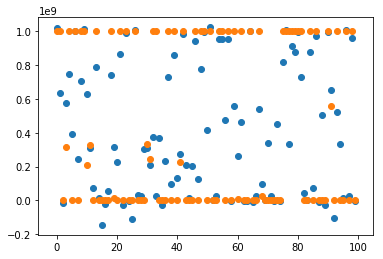

In [33]:
from matplotlib import pyplot as plt
x = np.arange(preds.shape[0])
cut = 100
plt.scatter(x[:cut],preds[:cut])
plt.scatter(x[:cut],testrY[:cut])

In [30]:
df.head()


,Stable,RHill12,RHill23,beta12,beta23,m1,a1,P1,e1,pomega1,...,Omega2,f2,m3,a3,P3,e3,pomega3,inc3,Omega3,f3
0,0,0.026033,0.023222,8.508586,15.826967,3.414016e-05,1.0,0.999983,0.005031,3.171041,...,1.573978,-0.567081,1.826900e-06,1.589043,2.003050,0.002515,-0.108162,0.065498,-1.192440,-0.614709
1,0,0.022704,0.031284,8.397002,15.367618,2.529838e-07,1.0,1.000000,0.010350,-3.564030,...,-1.749616,1.437355,1.955797e-05,1.671403,2.160777,0.072450,-0.343874,0.046939,-0.619350,0.192203
2,0,0.036304,0.032149,3.461288,25.229467,7.380789e-05,1.0,0.999963,0.051912,0.995149,...,-0.032550,-0.317958,1.477931e-07,1.936762,2.695151,0.003395,3.419165,0.014535,2.795101,1.685406
3,1,0.011704,0.014963,18.513681,19.145889,5.174804e-07,1.0,1.000000,0.000152,-3.328433,...,0.946351,-2.294238,1.287851e-06,1.503164,1.842927,0.057380,-0.829096,0.098014,-2.995941,-1.625763
4,0,0.006199,0.008634,5.494196,2.928938,5.106746e-07,1.0,1.000000,0.001457,1.738448,...,-0.455684,-1.074927,1.542321e-06,1.059346,1.090326,0.010325,-1.214839,0.011840,-1.253823,1.215392
